# Boost Switching regulator LM3478
- Supply: 20 V
- Output voltage: 40 V (theoretically up to 45 V)
	- Make the output voltage variable through some variable resistor (Manually / voltage controlled)

In [4]:

import math
#############! DESIGN PARAMETERS ##################
### Take from LTSpice simulation + overdimensioned
I_peak_A = 3 # Amps, for each bridge spike of 1 amp 180 degrees shifted
I_rms_A = math.sqrt(I_peak_A) # Amps (slightly overdimensioned already)
print(f"I_rms_A: {I_rms_A}")

### DIODE Choice:
# 40 V max
# RMS voltage max: 28 V
# 5 A RMS current max
V_diode = 0.85 # SS510 (Max current: 5 Amps, Max voltage: 100 V)
V_max_diode = 100 # 

### MOSFET Choice:
# NCE6005AS-mosfet -> usable in full bridge as well as sepic + MUCH cheaper
Vfet_gsth = 1.6 # Volt
Vfet_diode = 1.2 # Volt
Rfet_dsn = 32e-3 # At 3 amps, 2.5 V
Vfet_dsn = Rfet_dsn * I_rms_A
Vds_max = 60 # V
Vgs_max = 20 # V
Id_max = 5 # A
Id_peak = 24 # A (pulsed drain current)
print(f"Vfet_dsn {Vfet_dsn}")
freq_sw = 500e3

# Input voltage
Vin = 20

# Required Output Voltage
Vout = 40

I_rms_A: 1.7320508075688772
Vfet_dsn 0.05542562584220407


In [5]:

###! >>> Chose Inductor
L_ch = 20e-6

###! <<< Chose Inductor

D_boost = 1 - (Vin-Rfet_dsn*I_rms_A) / (Vout+V_diode)
print(f"Duty cycle: {D_boost}")

print(f"\r\n#### Inductor Selection ####\r\n")
L_min = D_boost * (1-D_boost) * Vin / (2 * I_rms_A * freq_sw)
print(f"L_min: {L_min*1e6} uH")

dIl_max = D_boost * Vin / (2 * freq_sw * L_ch)
Il_avg = I_rms_A / (1-D_boost)
Il_peak = Il_avg + dIl_max
print(f"Il_peak: {Il_peak}, Il_avg: {Il_avg}, dIl: {dIl_max}")
V_sense = 156e-3 # Volt
Vsl = 92e-3
ISW_limit = (I_rms_A / (1-D_boost) + (D_boost * Vin) / (2 * freq_sw * L_ch))
print(f"ISW_limit: {ISW_limit}")
print(f"\r\n#### Rsense selection ####\r\n")
R_sense = (V_sense - D_boost * Vsl) / ISW_limit
R_sense_max = 2 * Vsl * freq_sw * L_ch / (Vout - 2 * (Vin-0.01))
print(f"R_sense: {R_sense} should be < {R_sense_max}")
Rsl = (R_sense * (Vout - 2 * Vin) / (2*freq_sw * L_ch) - Vsl) / (40e-3)
if (Rsl < 0):
	print(f"No RSL addition necessary!")
else:
	print(f"RSL should be > {Rsl}")


print(f"\r\n#### DIODE selection ####\r\n")
Idiode_peak = I_rms_A / (1-D_boost) + dIl_max
print(f"Diode peak current: {Idiode_peak}")
print(f"\r\n#### INPUT CAPACITOR SELECTION ####\r\n")
Icin_rms = (Vout - Vin) / (2 * math.sqrt(3) * Vout * L_ch * freq_sw) * Vin
print(f"Cin RMS current: {Icin_rms} A")

print(f"\r\n#### OUTPUT CAPACITOR SELECTION ####\r\n")
Icout_rms = math.sqrt((1-D_boost) * (I_rms_A**2 * D_boost / (1-D_boost)**2 + dIl_max**2 / 3))
print(f"Icout_rms {Icout_rms} A")

Duty cycle: 0.5117607252348153

#### Inductor Selection ####

L_min: 2.8851542258469824 uH
Il_peak: 4.059305744839998, Il_avg: 3.5475450196051823, dIl: 0.5117607252348153
ISW_limit: 4.059305744839998

#### Rsense selection ####

R_sense: 0.02683168505275774 should be < 91.99999999998562
No RSL addition necessary!

#### DIODE selection ####

Diode peak current: 4.059305744839998

#### INPUT CAPACITOR SELECTION ####

Cin RMS current: 0.2886751345948129 A

#### OUTPUT CAPACITOR SELECTION ####

Icout_rms 1.7852594625227733 A


In [6]:
import numpy as np

Vout = 40
RF1 = 60e3 # 60 kOhms feedback in example
RF2 = (1.26 * RF1) / (Vout - 1.26)

print(f"Resistors: {RF1*1e-3:.2f} kOhm, {RF2*1e-3:.2f} kOhm")


# (RF2 / (RF1+RF2)) * Vout = 1.26 V -> this is the equation we have to rework to RF2 / RF1
# Vout / 1.26 = 1 + RF1 / RF2 
# Vout / 1.26 - 1 = RF1 / RF2
# RF2 = (1.26 V x RF1) / (Vout - 1.26 V)

def get_resistor_ratio(v_out):
	return ((v_out / 1.26) - 1)

resistor_array = np.array([0.470, 0.51, 0.56, 0.68, 0.82, 1, 1.2, 1.5, 1.8, 2, 2.2, 2.4, 2.7, 3, 3.3, 3.6, 3.9, 4.7, 4.99, 5.1, 5.6, 6.2, 
						6.8, 7.5, 8.2, 9.1, 10, 12, 13, 15, 20, 22, 24, 27, 30, 33, 39, 47, 51, 56, 68, 75, 82, 100, 150])
v_target = 40
RF1_ch = 30e3
RF2_ch = 1e3

######### DDR3L
print(f"---- V = {v_target} ----")
v_target_ratio = get_resistor_ratio(v_target)
r2_target_arr = np.round(resistor_array / v_target_ratio, 2)
r1_target_arr = np.round(resistor_array * v_target_ratio, 2)
print(f"{v_target} r1/r2: {v_target_ratio}")
print(f"R2 values {r2_target_arr}")
print(f"R1 values {r1_target_arr}")

for r1, r2 in zip(r1_target_arr, r2_target_arr):
	if (r1 in resistor_array):
		print(f"Perfect r1: {r1}, r2: {r1 / v_target_ratio}")
	if (r2 in resistor_array):
		print(f"Perfect r2 found: {r2}, r1: {r2 * v_target_ratio}")

vout_actual =1.26*(1+RF1_ch/RF2_ch)
print(f"offset: {((vout_actual - v_target) / v_target) * 100:.2f}%, vout: {vout_actual}")

I_fb = vout_actual / (RF1_ch+RF2_ch)
print(f"Power out: {vout_actual*I_fb}, Vout_actual {vout_actual}")

Resistors: 60.00 kOhm, 1.95 kOhm
---- V = 40 ----
40 r1/r2: 30.746031746031747
R2 values [0.02 0.02 0.02 0.02 0.03 0.03 0.04 0.05 0.06 0.07 0.07 0.08 0.09 0.1
 0.11 0.12 0.13 0.15 0.16 0.17 0.18 0.2  0.22 0.24 0.27 0.3  0.33 0.39
 0.42 0.49 0.65 0.72 0.78 0.88 0.98 1.07 1.27 1.53 1.66 1.82 2.21 2.44
 2.67 3.25 4.88]
R1 values [  14.45   15.68   17.22   20.91   25.21   30.75   36.9    46.12   55.34
   61.49   67.64   73.79   83.01   92.24  101.46  110.69  119.91  144.51
  153.42  156.8   172.18  190.63  209.07  230.6   252.12  279.79  307.46
  368.95  399.7   461.19  614.92  676.41  737.9   830.14  922.38 1014.62
 1199.1  1445.06 1568.05 1721.78 2090.73 2305.95 2521.17 3074.6  4611.9 ]
offset: -2.35%, vout: 39.06
Power out: 0.049215600000000005, Vout_actual 39.06


### Inductor high current (3-5 amps)
- Since the boost converter takes about 5 amps through its inductor, we need either a more expensive inductor, or 2 boost-stages which can perform current sharing naturally through CCM.
- However CCM doesn't mean that the current is shared perfectly.
- Try finding a smaller set of inductors with a higher current rating if possible, that might be usable for all cases (also for the SEPIC's, since they will need it to get from 5 -> 10 V at 1 A rms)

# Compensation

![](lm3478_control_loop.png)

## Dividing the control loop
There are 2 control paths
- The current measurement path
- The voltage feedback path

We can divide the transfer function into 3 main blocks. The total transfer function then becomes:

![](control_tot.png)

With the DC-gain $$A_{DC} = A_{CM} * A_{EA} * A_{FB}$$

### Block 1: Control to output equation

![](control_co.png)

For simplficiation we can usefor the common mode gain: $$A_{cm} = \frac{D'*R_{LOAD}}{2 * R_{SN}}$$

- z1-zero: output capacitor and series-resistance
- z2-zero: response of the output voltage
	- WHen the output voltage lowers -> switch turns on and increases current, which makes the voltage drop even more.
- p1-pole: output capacitor and load resistance together
- Complex poles: appear at half the switching frequency

### Block 2: Error amplifier

![](control_ea.png)


Transfer function:

$$
A_{\rm comp}(s)
=
A_{EA}\,\frac{1 + \dfrac{s}{\omega_{z3}}}{1 + \dfrac{s}{\omega_{p2}}}
$$



DC-Gain of this stage can be modelled as 
$$A_{EA} = g_m * R_{OUT}$$

- Here we add the zero Z3 for compensation

### Block 3: Feedback resistor

This is simply a resistive divider affecting the gain:

$$A_{FB} = \frac{R_{FB2}}{R_{FB1} + R_{FB2}}$$


### Compensation circuitry
We need to add an external zero by adding the Rc, Cc1 branch to the COMP pin of the LM3478.

Use the Nyquist Stability Theorem (phase margin analysis)
- Crossover frequency: frequency where open loop-gain is 0 dB.
- Crossover phase: phase at crossover frequency
- Phase margin: 180 degrees - crossover phase
	- If <= 0: unstable system
	- If too large -> overdamped
	- Ideally: 30-100 degrees

In [7]:

#! >>> Choice
R_sense_ch = 20e-3
C_out = 45e-6
R_esr = 30e-3
# COMPENSATION
# Place initial pole at infinity 1/RC = inf
Cc1_choice = 1e-12
Rc1_choice = 1
#! <<< Choice

R_load = vout_actual / I_rms_A

### BLOCK 1:
print(f"\r\n#### Control to out-loop ####")
wz1 =  1 / (C_out * R_esr)
wz2 = R_load * (Vin / vout_actual)**2 / L_ch
wp1 = 2 / (C_out * R_load)
Q_sw = 1 / (math.pi * (1-D_boost) * 3.320 / 1.515 + 0.5 - D_boost)

Acm = (1-D_boost) * R_load / (2 * R_sense_ch)
print(f"Acm:  {Acm} V/V")


### BLOCK 2:
R_out_err_ampl = 50e3 # Fixed value to model error ampligier (gm * R_out)
gm_ea = 800e-6

print(f"\r\n#### Error Amplifier Block ####")
wp2 = 1 / (Cc1_choice * R_out_err_ampl) # Amplifier pole
wz3 = 1 / (Cc1_choice * Rc1_choice) # Compensation zero

Aea = gm_ea * R_out_err_ampl # Tran

print(f"Aea: {Aea}, p2: {wp2*1e-3:.2f} krad/s, comp z3 {wz3:.2f} krad/s")

### BLOCK 3
print(f"\r\n#### Resistive Divider Block ####")
Afb = RF2_ch / (RF1_ch + RF2_ch)
print(f"Afb: {Afb}")
### TOTAL
Adc = Acm * Afb * Aea
adc_db = 20*math.log10(Adc)
print(f"Adc:  {Adc} V/V, {adc_db} dB")
print(f"wz2: {wz2}, fz2: {wz2 / (2*math.pi) * 1e-3} kHz -> Goal for crossover frequency {wz2 / (2*math.pi) * 1e-4} kHz")


#### Control to out-loop ####
Acm:  275.2607774118334 V/V

#### Error Amplifier Block ####
Aea: 40.0, p2: 20000.00 krad/s, comp z3 1000000000000.00 krad/s

#### Resistive Divider Block ####
Afb: 0.03225806451612903
Adc:  355.1751966604302 V/V, 51.00885259203983 dB
wz2: 295622.257649578, fz2: 47.04974359291621 kHz -> Goal for crossover frequency 4.704974359291621 kHz


### Bode plot drawing - No error-amplifier compensation

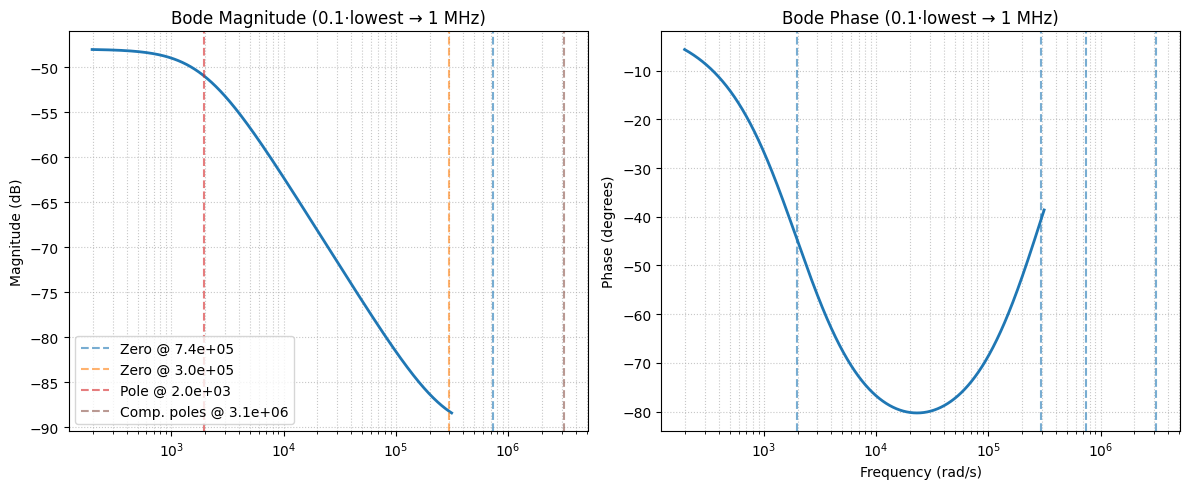

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# === User-adjustable parameters ===
# Take wz1, wz2, wz3, wp1, wp2 from previous calculations

fs    = freq_sw    # Complementary‐pole natural frequency (Hz)
Q     = Q_sw        # Complementary‐pole quality factor

K     = Adc       # Overall gain

# === Derived quantities ===
w0 = 2 * np.pi * fs           # Convert Hz → rad/s for the complex pole pair

# === Build numerator polynomial from the three real zeros ===
num = np.poly([-wz1, -wz2])

# === Build denominator polynomial ===
den_real    = np.poly([-wp1])
den_complex = [1, w0 / Q, w0**2]
den = np.polymul(den_real, den_complex)

# === Frequency axis for Bode plot, limited to 1 MHz ===
corners = np.array([wz1, wz2, wp1, w0])
wmin    = corners.min() / 10
wmax    = corners.max() / 10                # cap at 1 MHz (rad/s)
w       = np.logspace(np.log10(wmin), np.log10(wmax), num=2000)

# === Compute frequency response ===
s = 1j * w
H = K * np.polyval(num, s) / np.polyval(den, s)

# … (your existing definitions of w, H, wz1, wz2, wp1, w0) …

fig, (ax_mag, ax_ph) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# === Magnitude on the left ===
ax_mag.semilogx(w, 20 * np.log10(np.abs(H)), linewidth=2)
for f, col, lbl in [(wz1, 'C0', f'Zero @ {wz1:.1e}'),
                    (wz2, 'C1', f'Zero @ {wz2:.1e}'),
                    (wp1, 'C3', f'Pole @ {wp1:.1e}'),
                    (w0,  'C5', f'Comp. poles @ {w0:.1e}')]:
    ax_mag.axvline(f, color=col, ls='--', alpha=0.6, label=lbl)
ax_mag.set_title('Bode Magnitude (0.1⋅lowest → 1 MHz)')
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.grid(which='both', linestyle=':', alpha=0.7)
ax_mag.legend()

# === Phase on the right ===
ax_ph.semilogx(w, np.angle(H, deg=True), linewidth=2)
for f in (wz1, wz2, wp1, w0):
    ax_ph.axvline(f, ls='--', alpha=0.6)
ax_ph.set_title('Bode Phase (0.1⋅lowest → 1 MHz)')
ax_ph.set_xlabel('Frequency (rad/s)')
ax_ph.set_ylabel('Phase (degrees)')
ax_ph.grid(which='both', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()